In [ ]:
import sys
sys.path.append('../src')

import torch
from diffusers import StableDiffusionControlNetPipeline, DDIMScheduler, AutoencoderKL, ControlNetModel
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from ip_adapter import IPAdapter
import cv2
import numpy as np

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
ip_ckpt = "ip_adapter.bin"
device = "cuda"

In [86]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_blend_grid(ref, imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(
            img,
            box=(i%cols*w, i//cols*h),
            mask=ImageOps.invert(ref).convert('L')
            )
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00095,
    beta_end=0.016,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## ControlNet Depth

In [4]:
# load controlnet
controlnet_model_path = "lllyasviel/control_v11p_sd15_canny"
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
# load SD pipeline
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


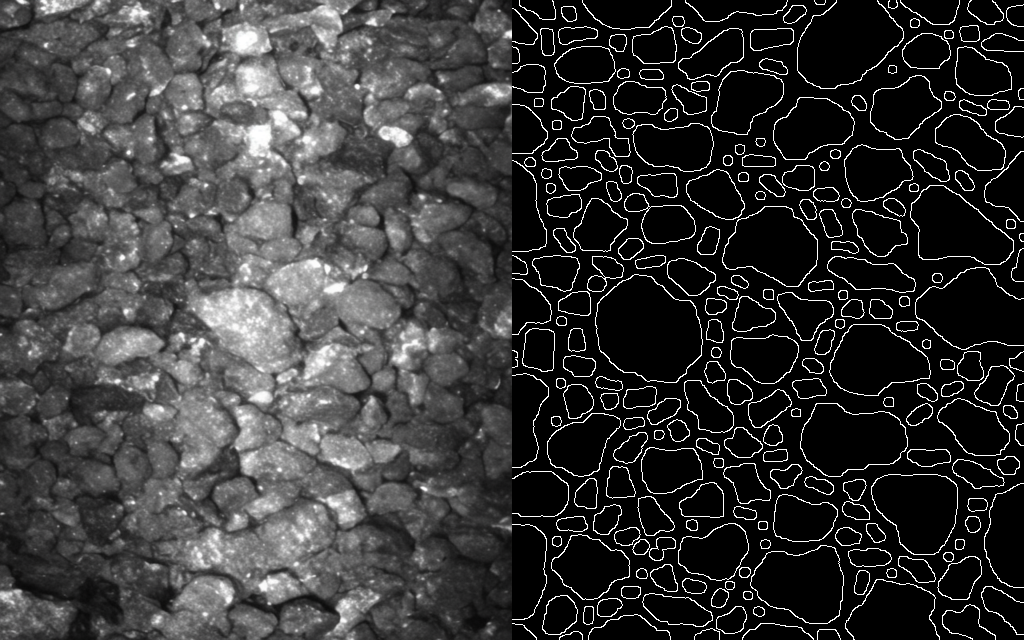

In [ ]:
# read image prompt
image = Image.open(r"")
height = 512
width = int(800 / 640 * height)
image = image.resize((height, width))

g_image = Image.open(r"")
g_image = g_image.convert('RGB')
g_image = g_image.resize(image.size)

g_image = np.array(g_image)
canny_image = cv2.Canny(g_image, 60, 100)

prompt_image = Image.fromarray(canny_image)

image_grid([image, prompt_image], 1, 2)

In [6]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

d:\vscode\ctci\IP-Adapter\ip_adapter\ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


100%|██████████| 50/50 [00:11<00:00,  4.34it/s]


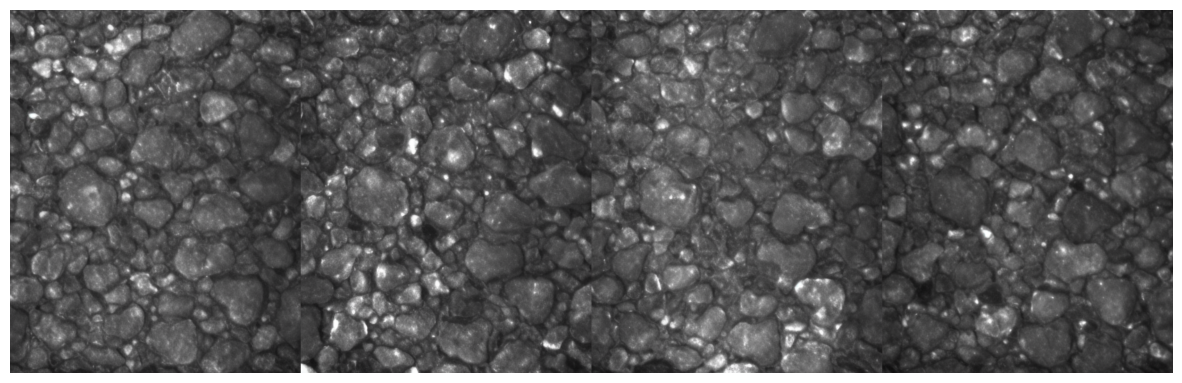

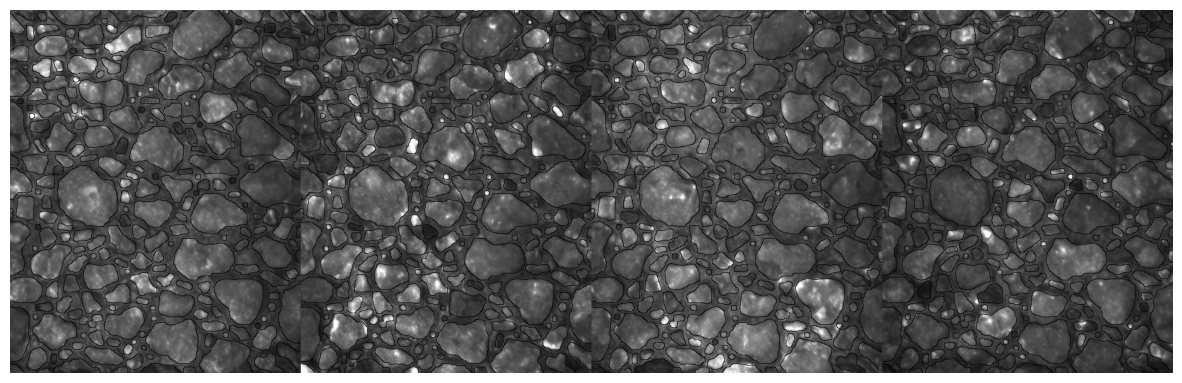

In [97]:
# generate image variations
images = ip_model.generate(
    pil_image=image,
    image=prompt_image,
    num_samples=4,
    num_inference_steps=50,
    seed=42,
    negative_prompt="best quality, regular shapes, even surface, round, metallic, slippery, polished, smooth",
    prompt="conveyer belt, monochrome, worst quality, poor lightning, rough, porous, angular, rocks",
    width=image.size[0],
    height=image.size[1],
    scale=1.5,
    guidance_scale=1,
    guess_mode=True,
    controlnet_conditioning_scale=4.0,
    )

grid_image = image_grid(images, 1, 4)
grid = image_blend_grid(prompt_image.convert('RGB'), images, 1, 4)

for ima in (grid_image, grid):
    plt.figure(figsize=(15, 8))
    plt.imshow(ima)
    plt.axis('off')